# Purpose
We would like to measure sticky header scrolling for the Vector 2022 skin post deployment analysis on enwiki.

Analysis ticket: https://phabricator.wikimedia.org/T329235

# Methodology

Data is pulled from `mediawiki_web_ui_scroll` schema, which captures scroll-to-top events on desktop. The usage of logged in users were logged before and after deployment. Need to confirm with engineer whether the sample rate had changed after deployment.
The usage of anonymous users were not logged before deployment. So we don't have a pre and post comparison for anonymous users.

As the schema does not capture skin version, below analysis is the overall scrolls usage from all skins, including vector and vector2022 and others. According to the analysis in [T327953](https://phabricator.wikimedia.org/T327953), the majority of users use the default skin: vector-2022. 

The analysis covered:
- Daily trends of scrolls per sessions on logged-in users
- Scrolls per sessions two weeks pre and post deloyment comparison


In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [54]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [16]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Analysis

## Daily trends

In [6]:
query_daily <- "
select is_anon, TO_DATE(meta.dt) AS event_date, count(distinct web_session_id) AS web_sessions, COUNT(1) AS scrolls 
FROM event.mediawiki_web_ui_scroll
WHERE year=2023 and month IN (1,2)
AND concat(normalized_host.project,'.', normalized_host.project_family)='en.wikipedia'  
GROUP BY is_anon,TO_DATE(meta.dt)

"

In [7]:
df_daily <- wmfdata::query_hive(query_daily)

Don't forget to authenticate with Kerberos using kinit



In [8]:
df_daily


is_anon,event_date,web_sessions,scrolls
<chr>,<chr>,<int>,<int>
false,2023-01-11,4842,33470
false,2023-02-04,41510,221927
true,2023-01-28,96131,135576
false,2023-01-12,5090,33937
false,2023-02-05,43469,236731
true,2023-01-29,106237,149914
false,2023-01-13,4870,33363
false,2023-02-06,50170,254980
true,2023-01-30,137788,191629


In [9]:
df_daily$event_date <- as.Date(df_daily$event_date )

In [10]:
head(df_daily)

,is_anon,event_date,web_sessions,scrolls
,<chr>,<date>,<int>,<int>
1,false,2023-01-11,4842,33470
2,false,2023-02-04,41510,221927
3,true,2023-01-28,96131,135576
4,false,2023-01-12,5090,33937
5,false,2023-02-05,43469,236731
6,true,2023-01-29,106237,149914


In [19]:
df_daily <- df_daily %>%
   mutate(
      scrolls_per_session=round(scrolls/web_sessions,6)
    )

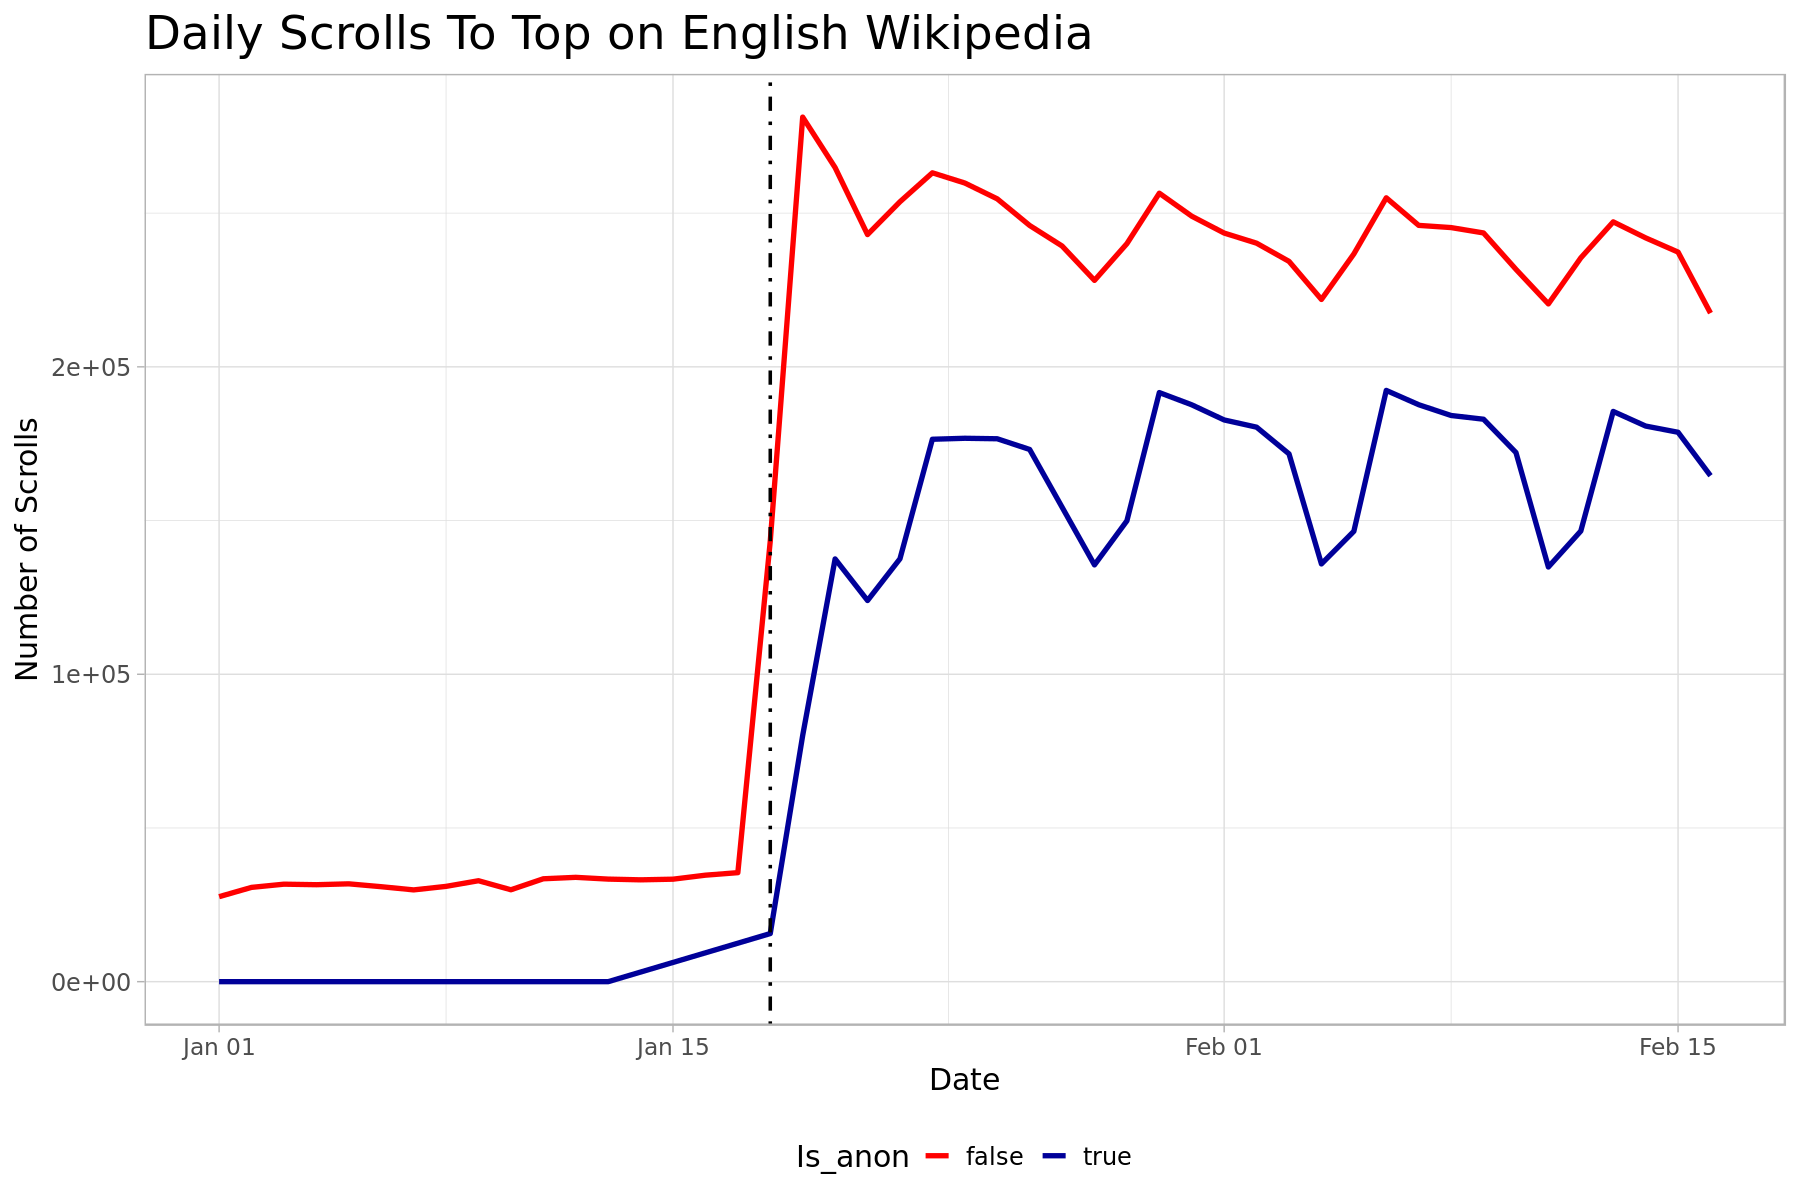

In [41]:
g_daily_scroll <- df_daily %>%
    # exclude the recent incompleted day
    slice(1:(n() - 2)) %>%
   ggplot(mapping=aes(x=event_date, y=scrolls, color=is_anon )) +
   geom_line( size = 1.5) +
   geom_vline(aes(xintercept = as.numeric(as.Date('2023-01-18'))), linetype="dotdash", color="black", size=1)+
   scale_color_manual(values= c("#FF0000", "#000099"), name = "Is_anon")  +
  labs(title = 'Daily Scrolls To Top on English Wikipedia',
     x = 'Date',
     y = 'Number of Scrolls') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
g_daily_scroll

In [39]:
head(df_daily)

,is_anon,event_date,web_sessions,scrolls,scrolls_per_session,period
,<chr>,<date>,<int>,<int>,<dbl>,<chr>
1,false,2023-01-11,4842,33470,6.912433,pre
2,false,2023-02-04,41510,221927,5.346350,NA
3,true,2023-01-28,96131,135576,1.410325,post
4,false,2023-01-12,5090,33937,6.667387,pre
5,false,2023-02-05,43469,236731,5.445973,NA
6,true,2023-01-29,106237,149914,1.411128,post


In [40]:
df_daily[order(df_daily$event_date),] %>% 
 filter(is_anon=='true') 


is_anon,event_date,web_sessions,scrolls,scrolls_per_session,period
<chr>,<date>,<int>,<int>,<dbl>,<chr>
true,2023-01-01,2,3,1.500000,NA
true,2023-01-03,1,1,1.000000,NA
true,2023-01-13,1,1,1.000000,pre
true,2023-01-18,11452,15652,1.366748,NA
true,2023-01-19,57434,80097,1.394592,post
true,2023-01-20,98029,137507,1.402718,post
true,2023-01-21,87659,123991,1.414470,post
true,2023-01-22,97121,137553,1.416305,post
true,2023-01-23,126323,176443,1.396761,post


__Note__

The usage of logged in users were logged before and after deployment.  
The usage of anonymous users were not logged before deployment. So we don't have pre and post comparison for anonymous users.

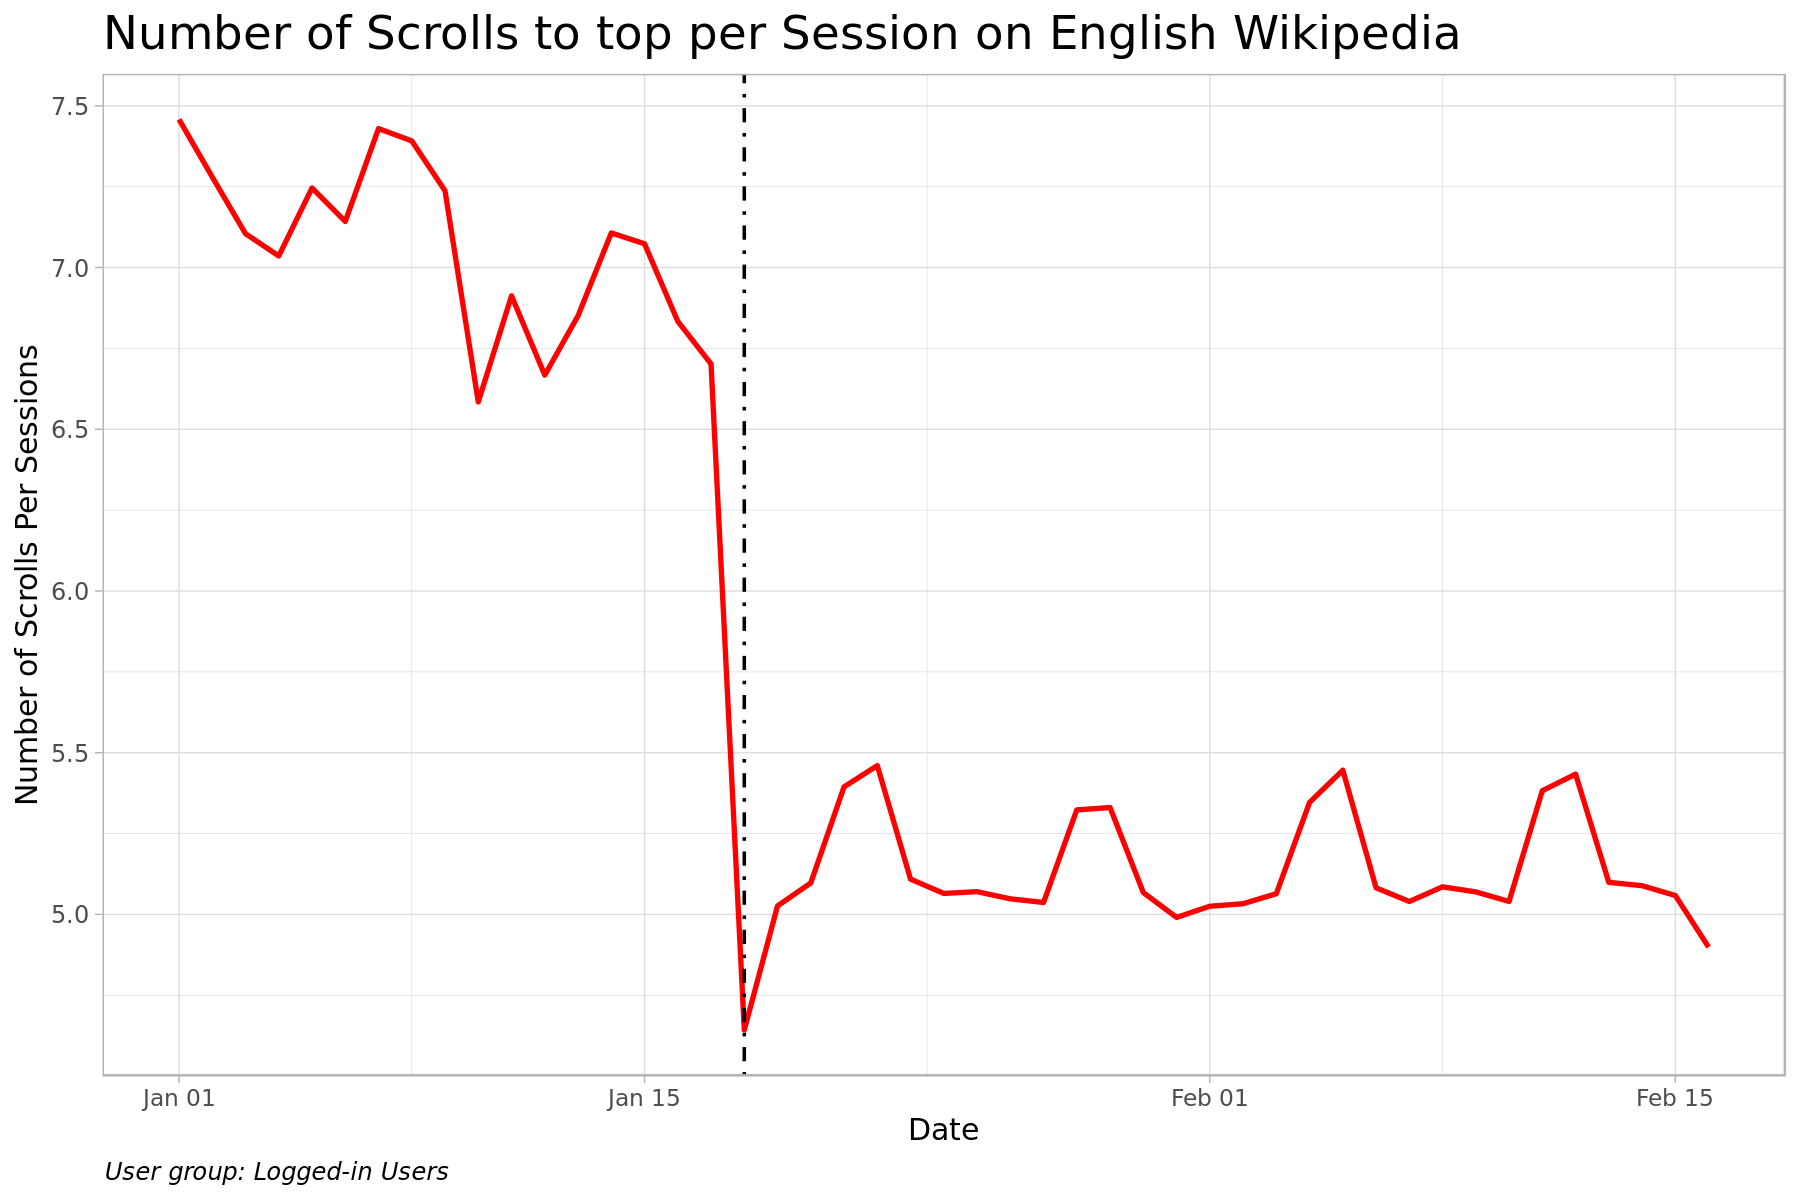

In [49]:
g_daily <- df_daily %>%
    # exclude the recent incompleted day
    slice(1:(n() - 2)) %>%
   filter(is_anon=='false') %>%
   ggplot(mapping=aes(x=event_date, y=scrolls_per_session )) +
   geom_line( size = 1.5, color="#FF0000") +
   geom_vline(aes(xintercept = as.numeric(as.Date('2023-01-18'))), linetype="dotdash", color="black", size=1)+
  labs(title = 'Number of Scrolls to top per Session on English Wikipedia',
     x = 'Date',
     y = 'Number of Scrolls Per Sessions',
     caption='User group: Logged-in Users') +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
g_daily 

## Two Weeks Pre and Post Deployment Comparison

In [23]:
df_daily <- df_daily %>%
   mutate(
    period= case_when(
        event_date >= '2023-01-04' & event_date <= '2023-01-17'  ~ 'pre',
        event_date >= '2023-01-19' & event_date <= '2023-02-01'  ~ 'post',      
        TRUE ~ 'NA'
    )
   )

In [50]:
df_pre_post <- df_daily %>%
   filter(is_anon=='false') %>%
   filter(period!='NA') %>%
   group_by(is_anon, period) %>%
   summarize(scrolls_per_sesssion_avg=sum(scrolls)/sum(web_sessions),.groups='drop') %>%
   spread(key=period, value=scrolls_per_sesssion_avg)

In [51]:
df_pre_post

is_anon,post,pre
<chr>,<dbl>,<dbl>
false,5.138855,6.999923


In [52]:
df_pre_post <- df_pre_post %>%
  mutate(
  change=round(post/pre-1, 4)
  )

In [53]:
df_pre_post

is_anon,post,pre,change
<chr>,<dbl>,<dbl>,<dbl>
false,5.138855,6.999923,-0.2659


# Summary

Scrolls per session on logged-in users decreased by 26.59% two weeks post deployment compared to two week pre deployment, from 7 scrolls per session session to 5.1 scrolls per session.